In [1]:
import matplotlib.pyplot as plt

from distributions.sequence import Sequence

import numpy as np
import pandas as pd
import seaborn as sns

import pickle
import json

import os

In [2]:
def get_name(run_name):
    return run_name.split("_")[0]

def get_length(run_name):
    return run_name.split("_")[1]

def theoretical_bound(T, sequence: Sequence):
    return 8 * sequence.m * np.sqrt(T * sequence.K * sequence.d * np.log(np.e * sequence.K / sequence.m) * np.log(np.sqrt(T) * sequence.m * sequence.sigma * sequence.R))



In [3]:
runs_inp = os.listdir("output")

algo_names = []

results = {}
for dist_name in runs_inp:
    results[dist_name] = {}

    lengths = os.listdir(f"output/{dist_name}")
    for length in lengths:
        results[dist_name][length] = {}

        algo_names = os.listdir(f"output/{dist_name}/{length}/0")
        algo_names = np.unique([x.split("_")[0] for x in algo_names])
        algo_names = algo_names[algo_names != "sequence.json"]
        print(algo_names)

        for algo_name in algo_names:
            results[dist_name][length][algo_name] = {
                "regret": [],
                "time_elapsed": [],
            }

            iterations = os.listdir(f"output/{dist_name}/{length}/")
            for iteration in iterations:
                with open(f"output/{dist_name}/{length}/{iteration}/{algo_name}_general_info.json", "r") as input_file:
                    input_dict = json.load(input_file)

                result_buffer = results[dist_name][length][algo_name]
                result_buffer["regret"].append(input_dict["regret"])
                result_buffer["time_elapsed"].append(input_dict["time_elapsed"])

for dist_name in results.keys():
    for length in results[dist_name].keys():
        for algo_name in results[dist_name][length].keys():
            for key in results[dist_name][length][algo_name].keys():
                results[dist_name][length][algo_name][key] = np.array(results[dist_name][length][algo_name][key])

['NonContextualExp3' 'OnePerContext' 'UniformRandom']
['NonContextualExp3' 'OnePerContext' 'UniformRandom']
['NonContextualExp3' 'OnePerContext' 'UniformRandom']
['NonContextualExp3' 'OnePerContext' 'UniformRandom']
['NonContextualExp3' 'OnePerContext' 'UniformRandom']


In [4]:
for dist_name in results.keys():
    for length in results[dist_name].keys():
        for algo_name in results[dist_name][length].keys():
            single_result = results[dist_name][length][algo_name]
            print(dist_name, length, algo_name, "regret:", np.average(single_result["regret"]), np.std(single_result["regret"]), np.average(single_result["time_elapsed"]))



BinaryContext1;12_IndependentBernoulli5;12 10000 NonContextualExp3 regret: 291.4 53.684634673247054 185.4233862400055
BinaryContext1;12_IndependentBernoulli5;12 10000 OnePerContext regret: 325.5 61.814642278346966 144.108824467659
BinaryContext1;12_IndependentBernoulli5;12 10000 UniformRandom regret: 304.5 56.4628196249532 3.1076205730438233
BinaryContext1;3_IndependentBernoulli5;3 10000 NonContextualExp3 regret: 162.8 54.48816385234503 160.26123514175416
BinaryContext1;3_IndependentBernoulli5;3 10000 OnePerContext regret: 191.9 44.74695520367839 137.78267204761505
BinaryContext1;3_IndependentBernoulli5;3 10000 UniformRandom regret: 180.0 59.64729666967314 3.1298428773880005
BinaryContext1;5_IndependentBernoulli12;5 10000 NonContextualExp3 regret: 460.4 53.968879921673384 1221.1798525333404
BinaryContext1;5_IndependentBernoulli12;5 10000 OnePerContext regret: 492.9 70.59667130963045 399.5637772798538
BinaryContext1;5_IndependentBernoulli12;5 10000 UniformRandom regret: 525.7 104.241114

<ipython-input-10-41aeb1d12f38>:8: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


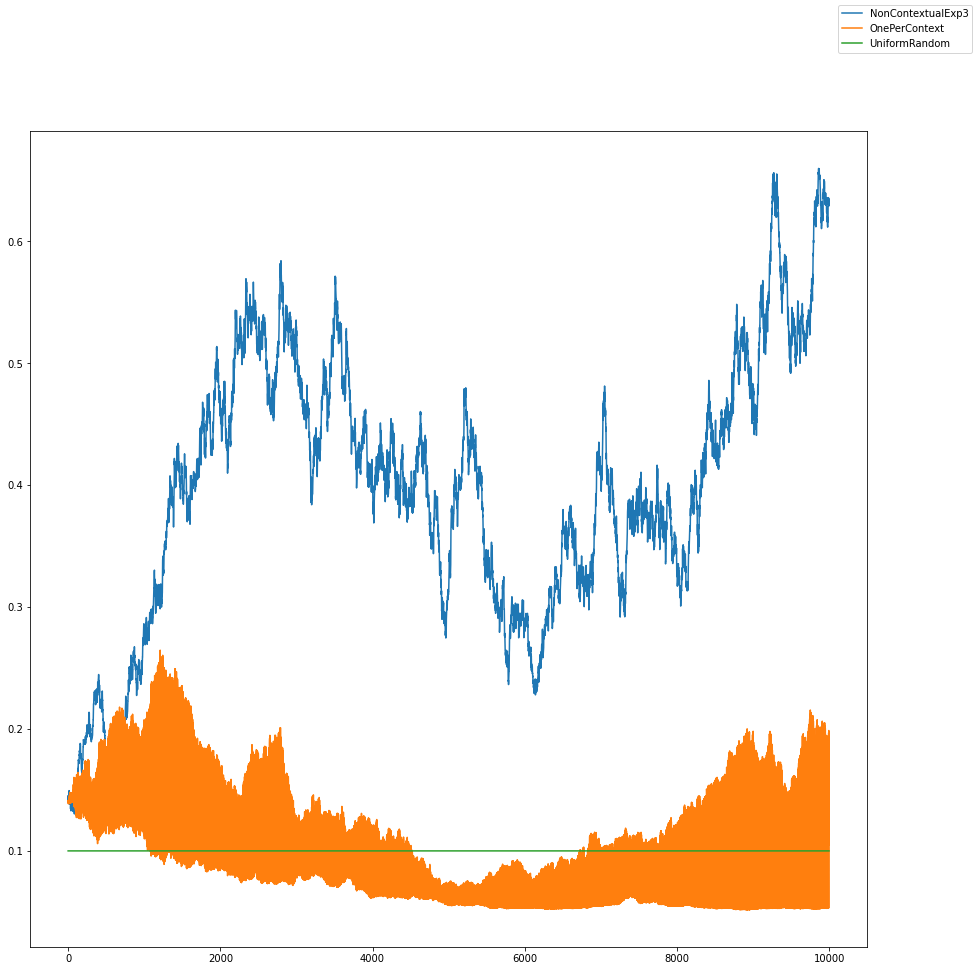

: 

In [10]:
fig, axs = plt.subplots(figsize=(15, 15))

for algo in algo_names:
    data = np.loadtxt(f"output/BinaryContext1;3_IndependentBernoulli5;3/10000/0/{algo}_probability_array.csv")[:, 0]
    axs.plot(data, label=algo)

fig.legend()
fig.show()

In [6]:
for name in ["FullBanditExp3"]:
    for length in results[name].keys():
        single_result = results[name][length]
        sequence = single_result["sequences"][0]

        theo = theoretical_bound(int(length), sequence)
        print(name, length, "regret:", np.average(single_result["regret"]), f"({theo:.2f})")

        data = single_result["probability_array"][:, :, 0]

        data1 = data[:, sequence.contexts[:-1, 0].astype(bool)]
        data2 = data[:, ~sequence.contexts[:-1, 0].astype(bool)]

        dataframe = pd.DataFrame(data1).melt()
        sns.lineplot(data=dataframe, x="variable", y="value", label="context 1")
        dataframe = pd.DataFrame(data2).melt()
        sns.lineplot(data=dataframe, x="variable", y="value", label="context 2")



KeyError: 'FullBanditExp3'